# Flax Diffusion
This is a partial port of [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/) from the Keras documentation, with the addition of conditional generation. I omit the Kernel Inception Distance because, to the best of my knowledge, there is currently easy way to load InceptionV3 in Flax. If you're interested in implementing KID or FID in Flax, [matthias-wright/jax-fid](https://github.com/matthias-wright/jax-fid) has a Flax implementation of InceptionV3.

In [119]:
import math
from typing import Any
import flax.linen as nn
from flax.training import train_state
import optax
import jax
import jax.numpy as jnp
from jax import lax
import numpy as np
from tqdm import tqdm
from keras.datasets import cifar10
import matplotlib.pyplot as plt

## Hyperparameters

In [192]:
# Sampling.
min_signal_rate = 0.02
max_signal_rate = 0.95

# Architecture.
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# Optimization.
learning_rate = 1e-4
epochs = 20

# Input.
batch_size = 32
image_width = 32
image_height = 32
channels = 3
num_classes = 10

## Data Preparation

In [152]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [153]:
x_train = np.concatenate([x_train, x_test], axis=0)
y_train = np.concatenate([y_train, y_test], axis=0)

In [154]:
x_train = x_train.astype('float32') / 255.

In [161]:
#x_repeated = x_train[:32]
#x_train = jnp.concatenate([x_train, x_repeated], axis=0)
x_train = jnp.reshape(
    x_train, (
        x_train.shape[0] // batch_size,
        batch_size,
        image_width,
        image_height,
        channels
    )
)

#y_repeated = y_train[:32]
#y_train = jnp.concatenate([y_train, y_repeated], axis=0)
y_train = jnp.reshape(
    y_train, (
        y_train.shape[0] // batch_size,
        batch_size,
        y_train.shape[-1]
    )
)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (1875, 32, 32, 32, 3)
y_train shape: (1875, 32, 1)


## Data Visualization

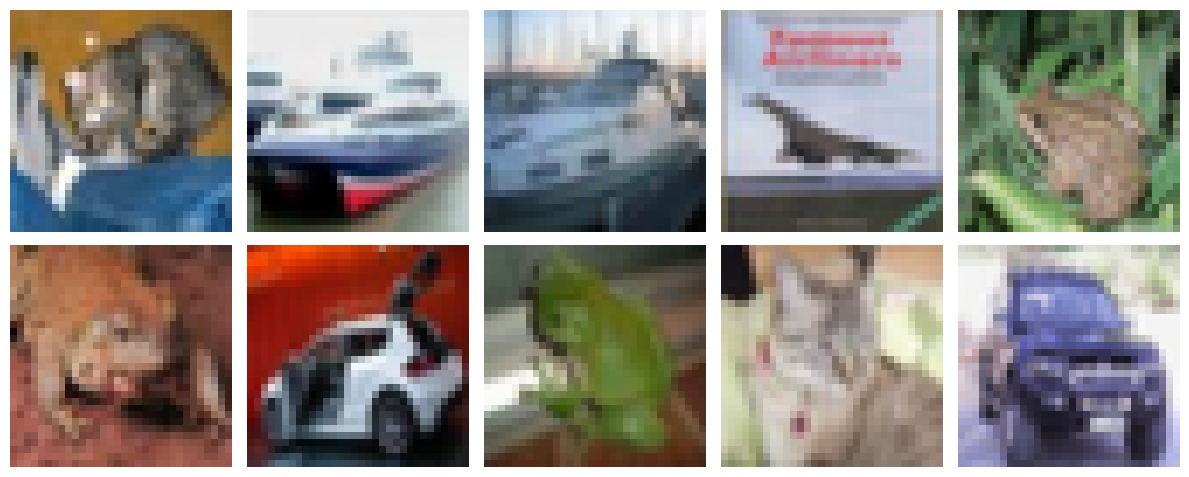

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, img in enumerate(x_test[0:10]):
    row_id = i // 5
    col_id = i - (5 * row_id)
    axs[row_id][col_id].imshow(img)
    axs[row_id][col_id].axis('off')
plt.tight_layout()
plt.show()

## Embedding

In [155]:
def sinusoidal_embedding(x, embedding_max_frequency):
    embedding_min_frequency = 1.0
    frequencies = jnp.exp(
        jnp.linspace(
            jnp.log(embedding_min_frequency),
            jnp.log(embedding_max_frequency),
            embedding_dims // 2
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = jnp.concatenate(
        [jnp.sin(angular_speeds * x), jnp.cos(angular_speeds * x)],
        axis = -1
    )
    return embeddings

## Architecture

In [196]:
class ResidualBlock(nn.Module):
    width: int

    @nn.compact
    def __call__(self, x, train: bool):
        input_width = x.shape[-1]
        if input_width == self.width:
            residual = x
        else:
            residual = nn.Conv(self.width, kernel_size=(1, 1))(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.Conv(self.width, kernel_size=(3, 3))(x)
        x = nn.activation.swish(x)
        x = nn.Conv(self.width, kernel_size=(3, 3))(x)
        x = x + residual
        return x

class DownBlock(nn.Module):
    width: int
    block_depth: int

    @nn.compact
    def __call__(self, x, train: bool):
        x, skips = x

        for _ in range(self.block_depth):
            x = ResidualBlock(self.width)(x, train)
            skips.append(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x

class UpBlock(nn.Module):
    width: int
    block_depth: int

    @nn.compact
    def __call__(self, x, train: bool):
        x, skips = x

        upsample_shape = (x.shape[0], x.shape[1] * 2, x.shape[2] * 2, x.shape[3])
        x = jax.image.resize(x, upsample_shape, method='bilinear')

        for _ in range(self.block_depth):
            x = jnp.concatenate([x, skips.pop()], axis=-1)
            x = ResidualBlock(self.width)(x, train)
        return x

class DDIM(nn.Module):
    channels: int
    num_classes: int
    widths: list
    block_depth: int
    embedding_max_frequency: float

    @nn.compact
    def __call__(self, x, train: bool):
        x, noise_variances, class_id = x

        e = sinusoidal_embedding(noise_variances, self.embedding_max_frequency)
        e = jax.image.resize(e, shape=x.shape, method='nearest')

        class_embedding = nn.Embed(self.num_classes, x.shape[1])(class_id)
        class_embedding = jnp.repeat(class_embedding, x.shape[2], axis=1)
        class_embedding = jnp.expand_dims(class_embedding, axis=-1)

        x = nn.Conv(self.widths[0], kernel_size=(1, 1))(x)
        x = jnp.concatenate([x, e, class_embedding], axis=-1)

        skips = []
        for width in self.widths[:-1]:
            x = DownBlock(width, self.block_depth)([x, skips], train)

        for _ in range(self.block_depth):
            x = ResidualBlock(self.widths[-1])(x, train)

        for width in reversed(self.widths[:-1]):
            x = UpBlock(width, self.block_depth)([x, skips], train)

        x = nn.Conv(self.channels, kernel_size=(3, 3), kernel_init=nn.initializers.zeros_init())(x)
        return x

## Diffusion Schedule

In [197]:
def diffusion_schedule(diffusion_times, max_signal_rate, min_signal_rate):
    start_angle = jnp.arccos(max_signal_rate)
    end_angle = jnp.arccos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = jnp.cos(diffusion_angles)
    noise_rates = jnp.sin(diffusion_angles)
    return noise_rates, signal_rates

## Training

In [198]:
class TrainState(train_state.TrainState):
    batch_stats: Any

def create_train_state(module, rng, learning_rate, image_width, image_height, channels):
    x = (jnp.ones([1, image_width, image_height, channels]), jnp.ones([1, 1, 1, 1]), jnp.array([[1]]))
    variables = module.init(rng, x, True)
    params = variables['params']
    batch_stats = variables['batch_stats']
    tx = optax.adam(learning_rate)
    #tx = optax.adam(create_learning_rate_fn(10, 30, learning_rate, x_train.shape[0]))
    train_state = TrainState.create(
        apply_fn=module.apply,
        params=params,
        tx=tx,
        batch_stats=batch_stats
    )
    return train_state

@jax.jit
def train_step(state, images, labels, parent_key, max_signal_rate, min_signal_rate):
    noise_key, diffusion_time_key = jax.random.split(parent_key, 2)
    batch_size = len(images)

    def loss_fn(params):
        noises = jax.random.normal(
            noise_key, (batch_size, images.shape[1], images.shape[2], channels)
        )
        diffusion_times = jax.random.uniform(diffusion_time_key, (batch_size, 1, 1, 1))
        noise_rates, signal_rates = diffusion_schedule(
            diffusion_times, max_signal_rate, min_signal_rate
        )
        noisy_images = signal_rates * images + noise_rates * noises

        pred_noises, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
             [noisy_images, noise_rates**2, labels],
             train=True,
             mutable=['batch_stats']
        )

        loss = jnp.mean((pred_noises - noises)**2)
        return loss, updates

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])
    return loss, state

In [199]:
def create_learning_rate_fn(warmup_epochs, num_epochs, base_learning_rate, steps_per_epoch):
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=base_learning_rate,
        transition_steps=warmup_epochs * steps_per_epoch
    )
    cosine_epochs = max(num_epochs - warmup_epochs, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=base_learning_rate,
        decay_steps=cosine_epochs * steps_per_epoch
    )
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[warmup_epochs * steps_per_epoch]
    )
    return schedule_fn

In [200]:
init_rng = jax.random.PRNGKey(0)
model = DDIM(channels, num_classes, widths, block_depth, embedding_max_frequency)
state = create_train_state(model, init_rng, learning_rate, image_width, image_height, channels)
del init_rng

In [201]:
steps_per_epoch = x_train.shape[0]

losses = []
for epoch in range(epochs):
    shuffle_key = jax.random.PRNGKey(epoch)
    #x_train = jax.random.shuffle(shuffle_key, x_train)
    #y_train = jax.random.shuffle(shuffle_key, y_train)
    losses_this_epoch = []
    for step in tqdm(range(steps_per_epoch)):
        images = x_train[step]
        labels = y_train[step]

        if images.shape[0] != batch_size:
            continue

        train_step_key = jax.random.PRNGKey(epoch * steps_per_epoch + step)
        loss, state = train_step(
            state,
            images,
            labels,
            train_step_key,
            max_signal_rate,
            min_signal_rate
        )
        losses_this_epoch.append(loss)

    average_loss = sum(losses_this_epoch) / len(losses_this_epoch)
    losses.append(average_loss)
    print(f'Epoch {epoch + 1} loss: {average_loss}')

100%|██████████| 1875/1875 [00:50<00:00, 37.14it/s]


Epoch 1 loss: 0.05555102601647377


100%|██████████| 1875/1875 [00:37<00:00, 50.29it/s]


Epoch 2 loss: 0.019642753526568413


100%|██████████| 1875/1875 [00:37<00:00, 49.36it/s]


Epoch 3 loss: 0.018046362325549126


100%|██████████| 1875/1875 [00:38<00:00, 49.06it/s]


Epoch 4 loss: 0.017367852851748466


100%|██████████| 1875/1875 [00:38<00:00, 48.33it/s]


Epoch 5 loss: 0.01662823185324669


100%|██████████| 1875/1875 [00:38<00:00, 48.67it/s]


Epoch 6 loss: 0.016268141567707062


100%|██████████| 1875/1875 [00:38<00:00, 48.23it/s]


Epoch 7 loss: 0.01603603921830654


100%|██████████| 1875/1875 [00:38<00:00, 48.11it/s]


Epoch 8 loss: 0.015827158465981483


100%|██████████| 1875/1875 [00:39<00:00, 48.02it/s]


Epoch 9 loss: 0.01553511805832386


100%|██████████| 1875/1875 [00:39<00:00, 47.71it/s]


Epoch 10 loss: 0.015436532907187939


100%|██████████| 1875/1875 [00:39<00:00, 47.86it/s]


Epoch 11 loss: 0.01541955303400755


100%|██████████| 1875/1875 [00:38<00:00, 48.08it/s]


Epoch 12 loss: 0.015082894824445248


100%|██████████| 1875/1875 [00:39<00:00, 47.83it/s]


Epoch 13 loss: 0.01507848035544157


100%|██████████| 1875/1875 [00:39<00:00, 47.40it/s]


Epoch 14 loss: 0.014948008581995964


100%|██████████| 1875/1875 [00:39<00:00, 47.97it/s]


Epoch 15 loss: 0.014959033578634262


100%|██████████| 1875/1875 [00:39<00:00, 47.16it/s]


Epoch 16 loss: 0.014903735369443893


100%|██████████| 1875/1875 [00:39<00:00, 47.87it/s]


Epoch 17 loss: 0.01495350617915392


100%|██████████| 1875/1875 [00:39<00:00, 47.59it/s]


Epoch 18 loss: 0.014927549287676811


100%|██████████| 1875/1875 [00:39<00:00, 47.70it/s]


Epoch 19 loss: 0.01471145823597908


100%|██████████| 1875/1875 [00:39<00:00, 48.06it/s]


Epoch 20 loss: 0.014755873940885067


## Training Visualization

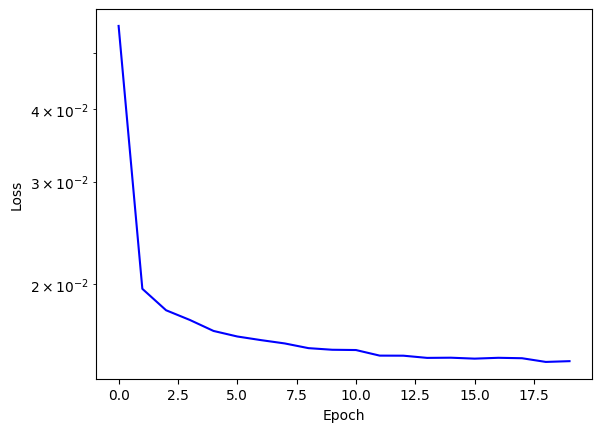

In [202]:
epoch_array = jnp.arange(epochs)
fig, ax = plt.subplots(1, 1)
ax.set_yscale("log")
ax.plot(epoch_array, losses, color='blue', label='loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.show()

## Sampling

In [203]:
def reverse_diffusion(
    classes,
    apply_fn,
    params,
    batch_stats,
    num_images,
    diffusion_steps,
    image_width,
    image_height,
    channels,
    noise_key = 0,
    initial_noise = None
):
    if initial_noise == None:
        initial_noise = jax.random.normal(
            jax.random.PRNGKey(noise_key),
            shape=(num_images, image_height, image_width, channels)
        )
    step_size = 1.0 / diffusion_steps

    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images

        diffusion_times = jnp.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(
            diffusion_times, max_signal_rate, min_signal_rate
        )
        pred_noises = lax.stop_gradient(
            apply_fn(
                {'params': params, 'batch_stats': batch_stats},
                [noisy_images, noise_rates**2, classes],
                train=False,
            )
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(
            next_diffusion_times, max_signal_rate, min_signal_rate
        )
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)

    return pred_images

In [204]:
classes = jnp.array([[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]])
pred_images = reverse_diffusion(
    classes = classes,
    apply_fn = state.apply_fn,
    params = state.params,
    batch_stats = state.batch_stats,
    num_images = classes.shape[0],
    diffusion_steps = 20,
    image_width = image_width,
    image_height = image_height,
    channels = channels,
    noise_key = 0
)

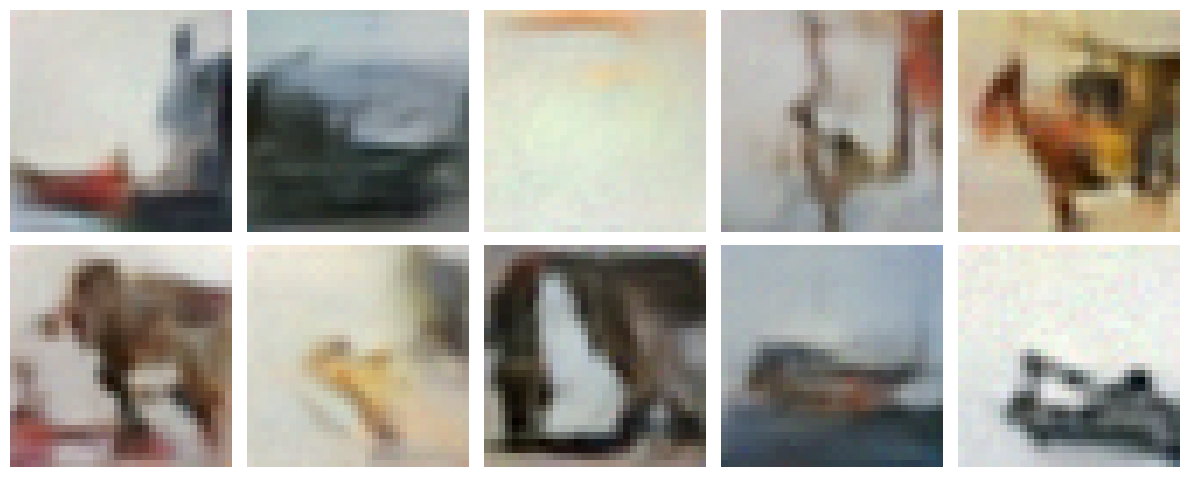

In [205]:
adjusted = (pred_images - jnp.min(pred_images))
adjusted /= jnp.max(adjusted)
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, img in enumerate(adjusted):
    row_id = i // 5
    col_id = i - (5 * row_id)
    axs[row_id][col_id].imshow(img)
    axs[row_id][col_id].axis('off')
plt.tight_layout()
plt.show()